In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, t, norm, multivariate_normal
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt
import scipy.stats as scs
from sklearn.metrics import r2_score

# Problem 1

In [2]:
df = pd.read_csv("problem1.csv")
x = df["x"].values

In [3]:
# First part
def cal_four_moments_formula(x):
    # Normalized
    n = len(x)
    u1 = np.sum(x) / n
    u2 = np.sum((x - u1) ** 2) / n
    u3 = np.sum(((x - u1) / np.sqrt(u2)) ** 3) / n
    u4 = np.sum((x - u1) ** 4) / (n * np.sqrt(u2) ** 4)
    return u1, u2, u3, u4

p1_1 = cal_four_moments_formula(x)
print(p1_1)

(1.0489703904839585, 5.4217934611998455, 0.8806086425277359, 26.12220078998972)


In [4]:
# Second part
def cal_four_moments_package(x):
    # Normalized
    u1 = np.mean(x)
    u2 = np.var(x)
    u3 = skew(x)
    u4 = kurtosis(x) + 3
    return u1, u2, u3, u4

p1_2 = cal_four_moments_package(x)
print(p1_2)

(1.0489703904839585, 5.4217934611998455, 0.8806086425277364, 26.122200789989723)


In [5]:
# Third part
def test_package_biased(alpha = 0.05):
    samples = 1000
    sample_size = 100
    means = []
    variances = []
    skews = []
    kurts = []
    for i in range(samples):
        random_normal_x = np.random.normal(0, 1, sample_size)
        means.append(np.mean(random_normal_x))
        variances.append(np.var(random_normal_x))
        skews.append(skew(random_normal_x))
        kurts.append(kurtosis(random_normal_x))

    t_value_m = np.mean(means) / (np.std(means) / np.sqrt(samples))
    t_value_v = (np.mean(variances) - 1)/ (np.std(variances) / np.sqrt(samples))
    t_value_s = np.mean(skews) / (np.std(kurts) / np.sqrt(samples))
    t_value_k = np.mean(kurts) / (np.std(kurts) / np.sqrt(samples))
    
    p_value_m = 2 * (1 - t.cdf(abs(t_value_m), samples-1))
    p_value_v = 2 * (1 - t.cdf(abs(t_value_v), samples-1))
    p_value_s = 2 * (1 - t.cdf(abs(t_value_s), samples-1))
    p_value_k = 2 * (1 - t.cdf(abs(t_value_k), samples-1))
    print(t_value_s)
    if p_value_m > alpha and p_value_v > alpha and p_value_s > alpha and p_value_k > alpha:
        # Not Reject
        print("We have no reason to reject the Null Hypothesis that Python package is not biased")
    else:
        # Reject
        print("We need to reject the hypothesis that Python package is not biased")
    print(p_value_m, p_value_v, p_value_s, p_value_k)
    
test_package_biased(0.05)


-0.11003890163901187
We need to reject the hypothesis that Python package is not biased
0.9206516592300447 0.166058390411294 0.9124006237659839 3.9628674685321386e-05


# Problem 2

In [6]:
df = pd.read_csv("problem2.csv")
x = df["x"].values.reshape(-1,1)
one = np.ones(len(x)).reshape(-1,1)
X = np.hstack((one,x))
y = df["y"].values

In [7]:
# First part
def OLS_fit(X, y):
    model = sm.OLS(y,X)
    result = model.fit()
    return result

# def MLE_fit(X,y):
#     model = sm.GLM(y, X, family=sm.families.Gaussian())
#     result = model.fit()
#     return result

def MLE_fit(params, X, y):
    std = params[0]
    beta_0, beta_1 = params[1:]
    residuals = y - (beta_0 + beta_1 * X[:,1])
    log_likelihood = np.sum(norm.logpdf(residuals, loc = 0, scale = std))
    return -log_likelihood

initial_params = [1, 0, 0]
p2_1_MLE = minimize(MLE_fit, initial_params, args=(X, y))

p2_1_OLS = OLS_fit(X,y)
print(p2_1_OLS.summary())
# print(p2_1_MLE.summary())
print(p2_1_MLE.x)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     104.6
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           5.59e-20
Time:                        23:58:58   Log-Likelihood:                -284.54
No. Observations:                 200   AIC:                             573.1
Df Residuals:                     198   BIC:                             579.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0874      0.071     -1.222      0.2

In [8]:
std_of_error_OLS = np.std(p2_1_OLS.resid)
std_of_error_MLE = np.std(y - np.dot(X,p2_1_MLE.x[1:]))
print(std_of_error_OLS, std_of_error_MLE)

1.003756319417732 1.003756319417732


In [9]:
r2_MLE = r2_score(y, np.dot(X,p2_1_MLE.x[1:]))
n = len(y) 
p = X.shape[1] - 1 
adj_r2_MLE = 1 - (1 - r2_MLE) * (n - 1) / (n - p - 1)
print(adj_r2_MLE)

0.3423018678252412


In [10]:
# Second part
def MLE_fit_t(params, X, y):
    df = params[0]
    std = params[1]
    beta_0, beta_1 = params[2:]
    residuals = y - (beta_0 + beta_1 * X[:,1])
    log_likelihood = np.sum(t.logpdf(residuals, df=df, loc = 0, scale = std))
    return -log_likelihood

initial_params = [1, 1, 0, 0]
p2_2_MLE_t = minimize(MLE_fit_t, initial_params, args=(X, y))
print(p2_2_MLE_t.x)

[ 7.15976826  0.85510362 -0.09726942  0.6750091 ]


In [11]:
r2_MLE_t = r2_score(y, np.dot(X,p2_2_MLE_t.x[2:]))
n = len(y) 
p = X.shape[1] - 1 
adj_r2_MLE_t = 1 - (1 - r2_MLE_t) * (n - 1) / (n - p - 1)
print(adj_r2_MLE_t)

0.3363196206776301


In [12]:
# Third part
df1 = pd.read_csv("problem2_x.csv")
df2 = pd.read_csv("problem2_x1.csv")

In [13]:
x = df1.values
one = np.ones(len(x)).reshape(-1,1)
X = np.hstack((one,x))    

In [14]:
df1 = pd.read_csv("problem2_x.csv")
df2 = pd.read_csv("problem2_x1.csv")

In [15]:
mean = np.mean(df1,axis = 0)
cov = np.cov(df1, rowvar = False)
dist = multivariate_normal(mean=mean, cov=cov)

In [16]:
mean_x1 = mean[0]
mean_x2 = mean[1]
cov_x1x1 = cov[0, 0]
cov_x1x2 = cov[0, 1]
cov_x2x1 = cov[1, 0]
cov_x2x2 = cov[1, 1]

In [17]:
def conditional_distribution(x1, mean_x1, mean_x2, cov_x1x1, cov_x1x2, cov_x2x1, cov_x2x2):
    conditional_mean_x2 = mean_x2 + cov_x1x2 * (1 / cov_x1x1) * (x1 - mean_x1)
    conditional_var_x2 = cov_x2x2 - cov_x2x1 * (1 / cov_x1x1) * cov_x1x2
    return conditional_mean_x2, conditional_var_x2

conditional_means = []
conditional_vars = []
for x1_obs in df2['x1']:
    mean_x2_given_x1, var_x2_given_x1 = conditional_distribution(x1_obs, mean_x1, mean_x2, cov_x1x2, cov_x1x2, cov_x2x1, cov_x2x2)
    conditional_means.append(mean_x2_given_x1)
    conditional_vars.append(var_x2_given_x1)
    
conditional_means = np.array(conditional_means)
conditional_vars = np.array(conditional_vars)

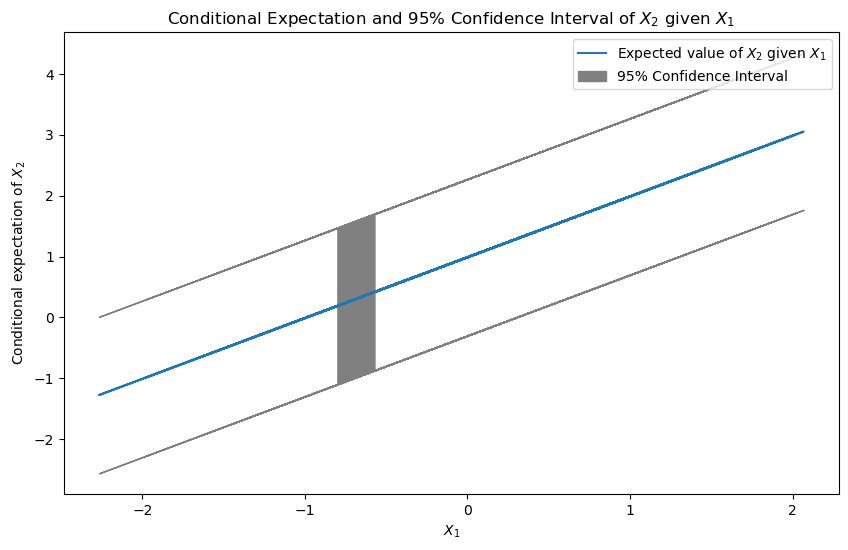

In [18]:
z_value = 1.96  
conf_intervals = z_value * np.sqrt(conditional_vars)

plot_data = pd.DataFrame({
    'x1': df2['x1'],
    'mean_x2_given_x1': conditional_means,
    'lower_bound': conditional_means - conf_intervals,
    'upper_bound': conditional_means + conf_intervals
})

plt.figure(figsize=(10, 6))
plt.plot(plot_data['x1'], plot_data['mean_x2_given_x1'], label='Expected value of $X_2$ given $X_1$')
plt.fill_between(plot_data['x1'], plot_data['lower_bound'], plot_data['upper_bound'], color='gray', alpha=1,
                 label='95% Confidence Interval')
plt.xlabel('$X_1$')
plt.ylabel('Conditional expectation of $X_2$')
plt.title('Conditional Expectation and 95% Confidence Interval of $X_2$ given $X_1$')
plt.legend()
plt.show()

# Problem3

In [19]:
df = pd.read_csv("problem3.csv")

D:\Anaconda\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


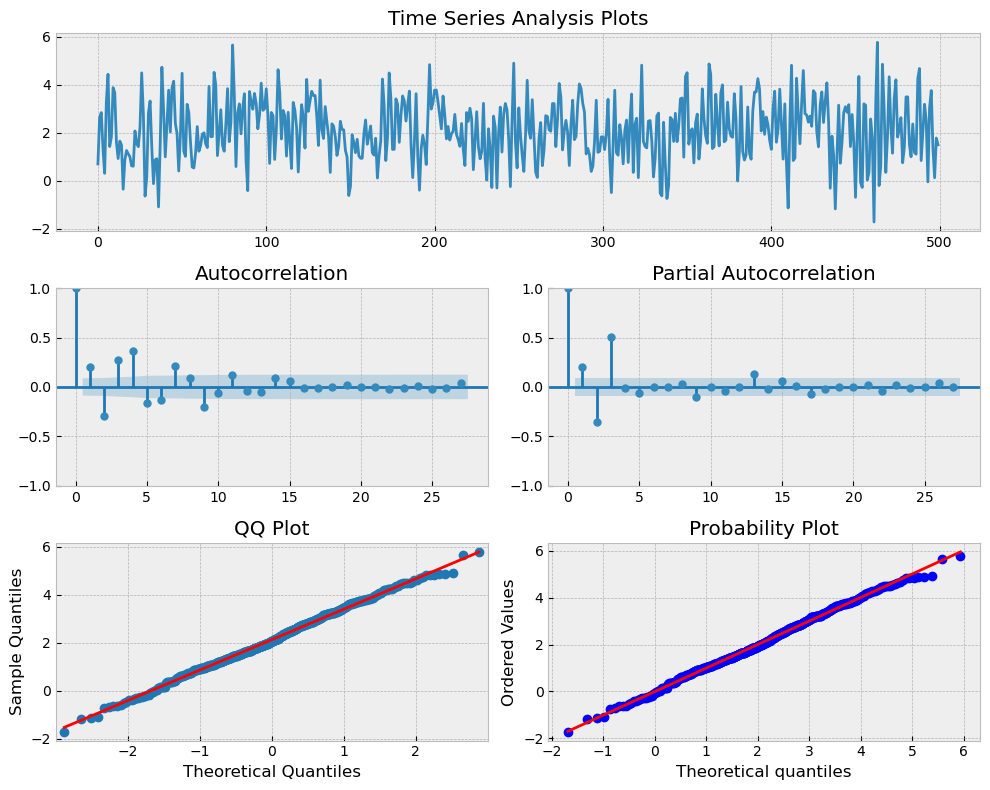

In [20]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

_ = tsplot(df['x'])

In [21]:
def fit_arima(data, ar_order, ma_order):
    model = ARIMA(data, order=(ar_order, 0, ma_order))
    model_fit = model.fit()
    return model_fit

arima_models = {}
aic_values = {}

# fit AR model
for ar_order in range(1, 4):
    model_label = f'ARIMA({ar_order}, 0, 0)'
    model_fit = fit_arima(df['x'], ar_order, 0)
    arima_models[model_label] = model_fit
    aic_values[model_label] = model_fit.aic

# fit MA model
for ma_order in range(1, 4):
    model_label = f'ARIMA(0, 0, {ma_order})'
    model_fit = fit_arima(df['x'], 0, ma_order)
    arima_models[model_label] = model_fit
    aic_values[model_label] = model_fit.aic
    
print(aic_values)
min_aic_key = min(aic_values, key=aic_values.get)
print(f"AR and MA model with the lowest aic value is {min_aic_key}")

{'ARIMA(1, 0, 0)': 1644.6555047688475, 'ARIMA(2, 0, 0)': 1581.079265904977, 'ARIMA(3, 0, 0)': 1436.6598066945883, 'ARIMA(0, 0, 1)': 1567.4036263707874, 'ARIMA(0, 0, 2)': 1537.941206380739, 'ARIMA(0, 0, 3)': 1536.8677087350302}
AR and MA model with the lowest aic value is ARIMA(3, 0, 0)


D:\Anaconda\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


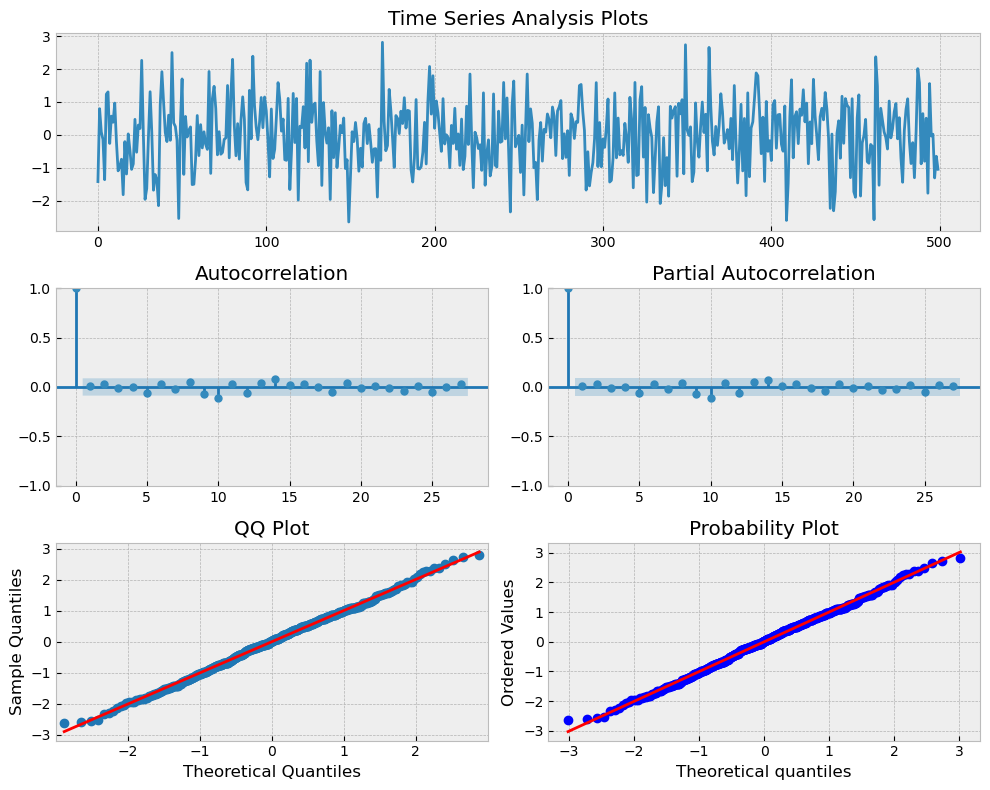

In [22]:
_ = tsplot(fit_arima(df['x'], 3, 0).resid)